Bank Dataset

In [ ]:
from google.colab import drive # mounting the google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/complaints.csv")

In [ ]:
occurrences = data['product'].value_counts()
print(occurrences)

product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64


In [ ]:
data.head(20)

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
5,5,credit_reporting,payment history missing credit report made mis...
6,6,credit_reporting,va date complaint experian credit bureau invol...
7,7,credit_reporting,account reported abbreviated name full name se...
8,8,credit_reporting,account reported abbreviated name full name se...
9,9,credit_reporting,usdoexxxx account reported abbreviated name fu...


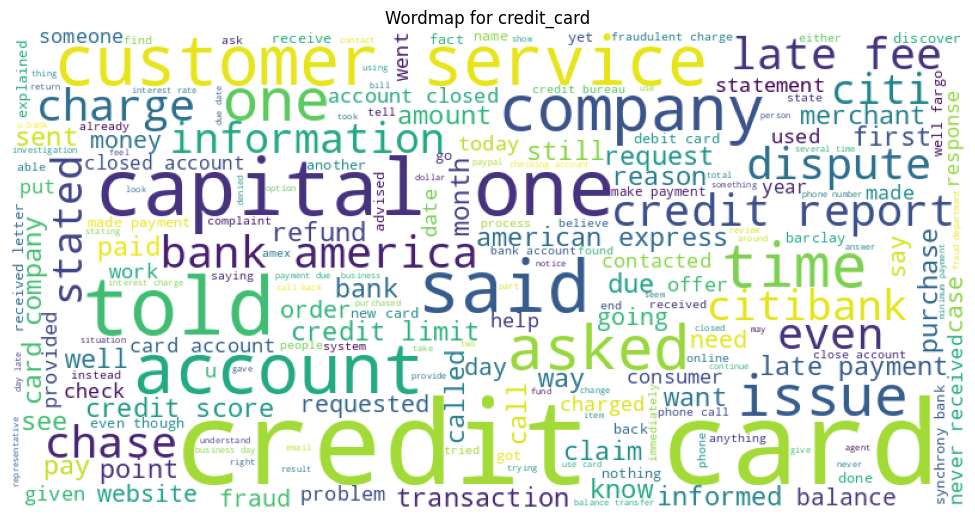

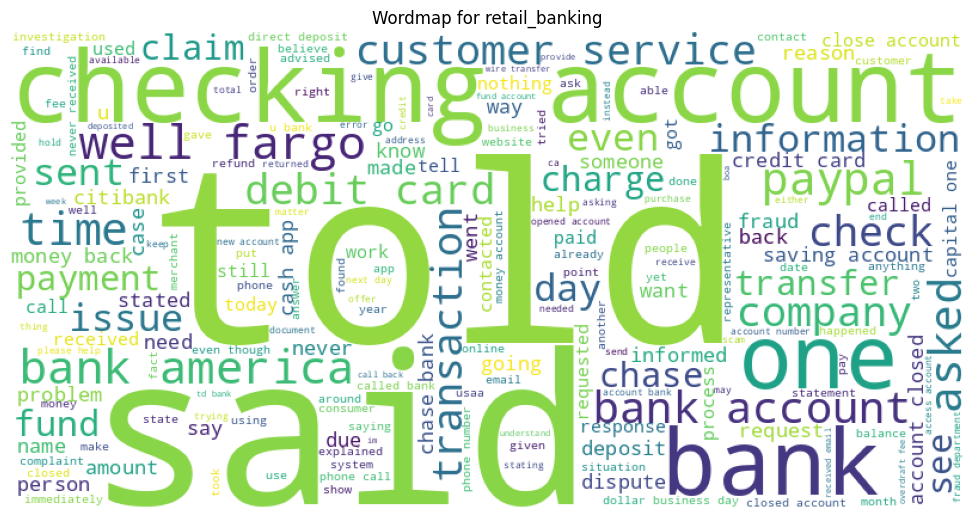

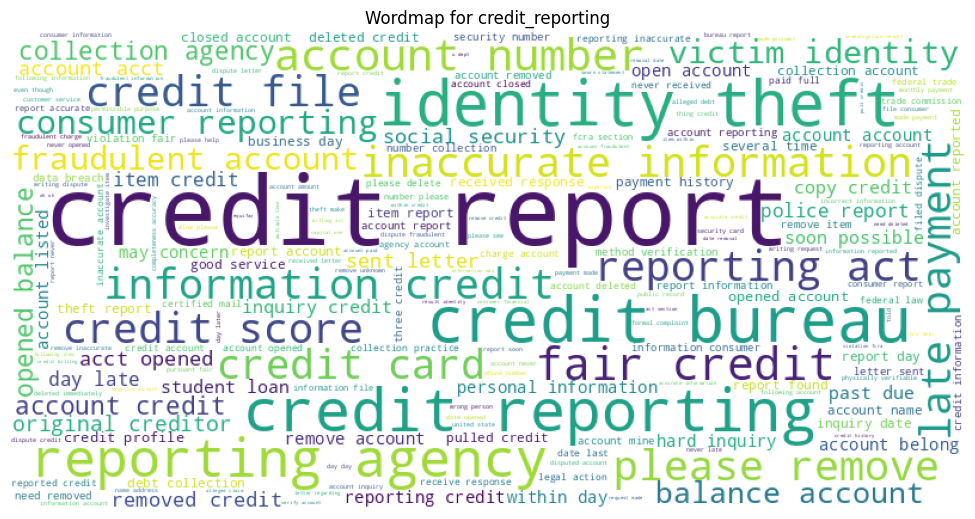

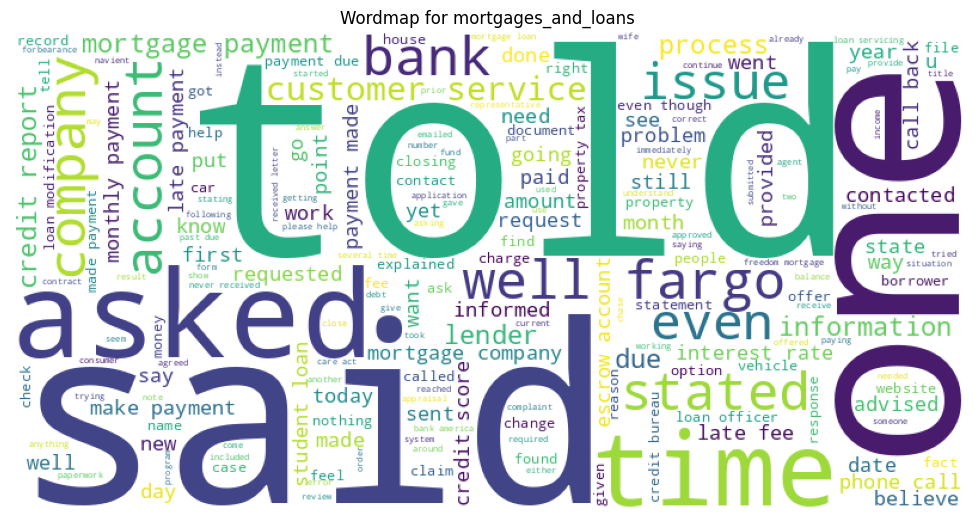

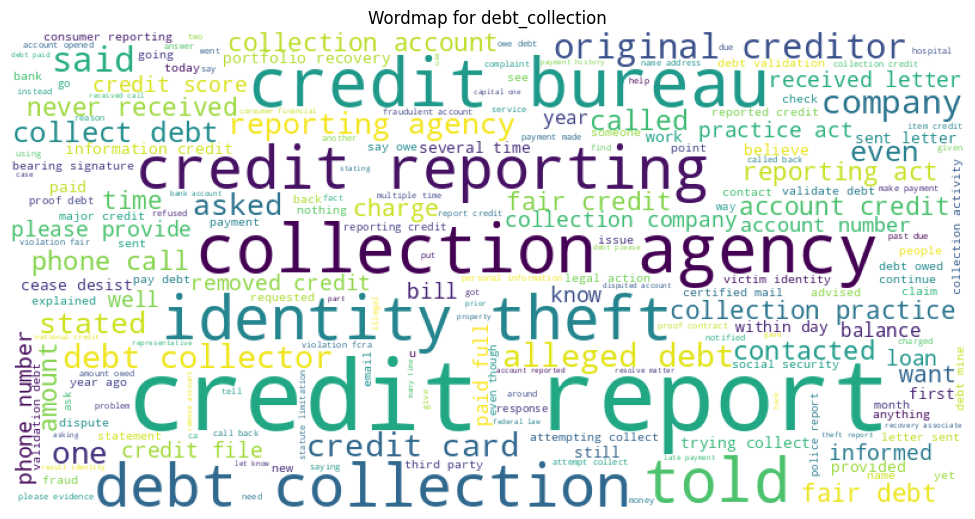

In [ ]:
# prompt: create word maps for different products

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame loaded from 'complaints.csv'
# df = pd.read_csv("complaints.csv")

def create_wordmap(product):
    # Filter DataFrame for the specified product
    product_df = data[data["product"] == product]

    # Combine all consumer complaint narratives for the product
    text = " ".join(product_df["narrative"].astype(str))

    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Wordmap for {product}")  # Added title for clarity
    plt.tight_layout(pad=0)
    plt.show()

# Example usage (replace with your actual product names):
products_to_analyze = data["product"].unique()

for product in products_to_analyze:
    create_wordmap(product)

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download required NLTK resources
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Extracting product type and narrative for further analysis
data['product'] = data['product'].str.lower()
data['narrative'] = data['narrative'].str.lower()

# Preview product and narrative columns
print(data[['product', 'narrative']].head())


            product                                          narrative
0       credit_card  purchase order day shipping amount receive pro...
1       credit_card  forwarded message date tue subject please inve...
2    retail_banking  forwarded message cc sent friday pdt subject f...
3  credit_reporting  payment history missing credit report speciali...
4  credit_reporting  payment history missing credit report made mis...


In [ ]:
# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def get_sentiment(text):
    if pd.isnull(text):
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return sid.polarity_scores(text)

# Apply sentiment analysis
data['sentiment'] = data['narrative'].apply(get_sentiment)

# Split sentiment into separate columns
sentiment_df = pd.json_normalize(data['sentiment'])
data = pd.concat([data, sentiment_df], axis=1)

# Drop the nested sentiment column
data = data.drop(columns=['sentiment'])

# Preview sentiment columns
print(data[['narrative', 'compound', 'pos', 'neg', 'neu']].head())


                                           narrative  compound    pos    neg  \
0  purchase order day shipping amount receive pro...    0.3818  0.080  0.078   
1  forwarded message date tue subject please inve...    0.9451  0.244  0.116   
2  forwarded message cc sent friday pdt subject f...   -0.8020  0.218  0.215   
3  payment history missing credit report speciali...   -0.0449  0.087  0.102   
4  payment history missing credit report made mis...   -0.0449  0.092  0.108   

     neu  
0  0.842  
1  0.640  
2  0.567  
3  0.811  
4  0.800  


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=20, stop_words='english')

# Fit and transform narratives
keywords_matrix = vectorizer.fit_transform(data['narrative'].fillna(''))
keywords_df = pd.DataFrame(keywords_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add keyword frequencies to the main dataframe
data = pd.concat([data, keywords_df], axis=1)

# Preview keywords
print(keywords_df.head())


   account  bank  card  collection  company  consumer  credit  day  debt  \
0        0     0     1           0        1         0       0    2     0   
1        3     5     4           0        5         0       7    0     1   
2        4     0     4           0        0         2       0    0     0   
3        3     3     0           0        0         0       3    0     0   
4        3     3     0           0        0         0       3    0     0   

   dispute  information  letter  loan  payment  received  report  reporting  \
0        2            0       0     0        0         1       0          0   
1        0            0       0     0        1         0       0          0   
2        0            0       0     0        2         0       0          1   
3        0            0       2     5        6         0       4          0   
4        0            0       2     3        6         0       4          0   

   sent  time  told  
0     2     1     0  
1     1     0     1  
2 

In [ ]:
# Define urgency keywords
urgency_keywords = ['urgent', 'immediately', 'waiting', 'frustrating', 'illegal', 'outrageous']

# Function to check for urgency
def check_urgency(text):
    if pd.isnull(text):
        return 0
    return int(any(word in text for word in urgency_keywords))

# Apply urgency check
data['is_urgent'] = data['narrative'].apply(check_urgency)

# Preview urgency column
print(data[['narrative', 'is_urgent']].head())


                                           narrative  is_urgent
0  purchase order day shipping amount receive pro...          0
1  forwarded message date tue subject please inve...          0
2  forwarded message cc sent friday pdt subject f...          1
3  payment history missing credit report speciali...          1
4  payment history missing credit report made mis...          1


In [ ]:
# Count the occurrences of each product type
product_counts = data['product'].value_counts()

# Print product counts
print(product_counts)


product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert narratives to TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['narrative'].fillna(''))

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display top words in each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 10)


Topic 1:
debt credit account collection reporting report information letter company bureau
Topic 2:
credit account report inquiry identity theft information fraudulent victim reporting
Topic 3:
credit report item account remove day dispute unknown opened pulled
Topic 4:
card bank account money called told phone time charge said
Topic 5:
payment loan credit late mortgage account paid month time score


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract bigrams and trigrams
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=20)
ngrams_matrix = vectorizer.fit_transform(data['narrative'].fillna(''))
ngrams_df = pd.DataFrame(ngrams_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display top n-grams
print("Top N-grams:")
print(ngrams_df.sum().sort_values(ascending=False).head(10))


Top N-grams:
credit report       99386
credit bureau       31366
identity theft      29018
credit card         28246
credit reporting    26674
reporting agency    20484
credit score        15439
account number      14803
late payment        14564
fair credit         14359
dtype: int64


In [ ]:
import pandas as pd
data1 = pd.read_csv("/content/drive/MyDrive/customer_support_tickets.csv")

In [ ]:
print(data1.head())

   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       2021-03-22  Technical issue   
1          Female       LG Smart TV       2021-05-22  Technical issue   
2           Other          Dell XPS       2020-07-14  Technical issue   
3          Female  Microsoft Office       2020-11-13  Billing inquiry   
4          Female  Autodesk AutoCAD       2020-02-04  Billing inquiry   

             Ticket Subject  \
0             Product setup   
1  Peripheral compatibil

In [ ]:
# Convert relevant columns to datetime for easier analysis
data1['Date of Purchase'] = pd.to_datetime(data1['Date of Purchase'], errors='coerce')
data1['First Response Time'] = pd.to_datetime(data1['First Response Time'], errors='coerce')
data1['Time to Resolution'] = pd.to_datetime(data1['Time to Resolution'], errors='coerce')

# 1. Ticket Type Distribution
ticket_type_distribution = data1['Ticket Type'].value_counts()

# 2. Average Customer Satisfaction Rating
avg_satisfaction = data1['Customer Satisfaction Rating'].mean()

# Identify tickets with low satisfaction (rating < 3)
low_satisfaction_tickets = data1[data1['Customer Satisfaction Rating'] < 3]

# 3. Response Time Analysis (in hours)
data1['Response Time (hours)'] = (data1['Time to Resolution'] - data1['First Response Time']).dt.total_seconds() / 3600
avg_response_time = data1['Response Time (hours)'].mean()

# 4. Ticket Priority Distribution
priority_distribution = data1['Ticket Priority'].value_counts()

# 5. Gender-wise Ticket Distribution
gender_ticket_distribution = data1['Customer Gender'].value_counts()

# 6. Tickets that can be automated based on description
# Define keywords indicating simple/automatable issues
automatable_keywords = ['setup', 'access', 'compatibility', 'network', 'data loss']
automatable_tickets = data1[data1['Ticket Description'].str.contains('|'.join(automatable_keywords), case=False, na=False)]

# Display the results
print("Ticket Type Distribution:\n", ticket_type_distribution)
print("\nAverage Customer Satisfaction Rating:", avg_satisfaction)
print("\nLow Satisfaction Tickets:\n", low_satisfaction_tickets[['Ticket ID', 'Customer Name', 'Customer Satisfaction Rating']])
print("\nAverage Response Time (hours):", avg_response_time)
print("\nTicket Priority Distribution:\n", priority_distribution)
print("\nGender-wise Ticket Distribution:\n", gender_ticket_distribution)
print("\nTickets That Can Be Automated:\n", automatable_tickets[['Ticket ID', 'Ticket Description']])




Ticket Type Distribution:
 Ticket Type
Refund request          1752
Technical issue         1747
Cancellation request    1695
Product inquiry         1641
Billing inquiry         1634
Name: count, dtype: int64

Average Customer Satisfaction Rating: 2.991332611050921

Low Satisfaction Tickets:
       Ticket ID      Customer Name  Customer Satisfaction Rating
4             5  Alexander Carroll                           1.0
10           11      Joseph Moreno                           1.0
11           12     Brandon Arnold                           1.0
29           30      Austin George                           1.0
35           36         Joann King                           1.0
...         ...                ...                           ...
8430       8431  Joshua Villanueva                           2.0
8435       8436      Brandi Willis                           1.0
8440       8441      Margaret Ward                           1.0
8448       8449    Reginald Kaiser                     

In [ ]:
# Categorize customers by age groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 100]
age_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']
data1['Age Group'] = pd.cut(data1['Customer Age'], bins=age_bins, labels=age_labels)

# Analyze ticket distribution by age group and gender
age_group_distribution = data1['Age Group'].value_counts()
gender_age_distribution = data1.groupby(['Customer Gender', 'Age Group']).size()

print("\nTicket Distribution by Age Group:\n", age_group_distribution)
print("\nTicket Distribution by Gender and Age Group:\n", gender_age_distribution)



Ticket Distribution by Age Group:
 Age Group
50-60    1675
40-50    1592
20-30    1586
60-70    1570
30-40    1541
<20       505
70+         0
Name: count, dtype: int64

Ticket Distribution by Gender and Age Group:
 Customer Gender  Age Group
Female           <20          183
                 20-30        558
                 30-40        516
                 40-50        538
                 50-60        567
                 60-70        525
                 70+            0
Male             <20          156
                 20-30        559
                 30-40        533
                 40-50        556
                 50-60        544
                 60-70        548
                 70+            0
Other            <20          166
                 20-30        469
                 30-40        492
                 40-50        498
                 50-60        564
                 60-70        497
                 70+            0
dtype: int64


<ipython-input-17-e8c35e5c6a9d>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_age_distribution = data1.groupby(['Customer Gender', 'Age Group']).size()


In [ ]:
# Identify unresolved or escalated tickets
unresolved_tickets = data1[data1['Ticket Status'] == 'Pending Customer Response']
escalation_by_type = unresolved_tickets['Ticket Type'].value_counts()

# Long response time tickets
data1['Response Time (hours)'] = (
    pd.to_datetime(data1['First Response Time']) - pd.to_datetime(data1['Date of Purchase'])
).dt.total_seconds() / 3600

long_response_tickets = data1[data1['Response Time (hours)'] > 24]

print("\nUnresolved Tickets by Type:\n", escalation_by_type)
print("\nTickets with Long Response Times:\n", long_response_tickets[['Ticket ID', 'Ticket Type', 'Response Time (hours)']])



Unresolved Tickets by Type:
 Ticket Type
Cancellation request    597
Refund request          592
Product inquiry         576
Technical issue         565
Billing inquiry         551
Name: count, dtype: int64

Tickets with Long Response Times:
       Ticket ID      Ticket Type  Response Time (hours)
0             1  Technical issue           19236.260000
1             2  Technical issue           17776.760556
2             3  Technical issue           25259.243889
3             4  Billing inquiry           22327.494444
4             5  Billing inquiry           29112.211667
...         ...              ...                    ...
8455       8456  Billing inquiry           20390.251944
8458       8459  Billing inquiry           24929.436389
8462       8463   Refund request           22896.605000
8466       8467  Technical issue           15681.739444
8467       8468  Product inquiry           14250.473333

[5650 rows x 3 columns]


In [ ]:
# Ticket count by product purchased
product_ticket_counts = data1['Product Purchased'].value_counts()

# Average satisfaction rating by product
satisfaction_by_product = data1.groupby('Product Purchased')['Customer Satisfaction Rating'].mean()

print("\nTicket Count by Product:\n", product_ticket_counts)
print("\nAverage Satisfaction Rating by Product:\n", satisfaction_by_product)



Ticket Count by Product:
 Product Purchased
Canon EOS                         240
GoPro Hero                        228
Nest Thermostat                   225
Philips Hue Lights                221
Amazon Echo                       221
LG Smart TV                       219
Sony Xperia                       217
Roomba Robot Vacuum               216
Apple AirPods                     213
LG OLED                           213
iPhone                            212
Sony 4K HDR TV                    210
Garmin Forerunner                 208
LG Washing Machine                208
Canon DSLR Camera                 206
Nikon D                           204
Nintendo Switch Pro Controller    203
Google Pixel                      203
Fitbit Charge                     202
Sony PlayStation                  202
HP Pavilion                       200
Microsoft Office                  200
Amazon Kindle                     198
Google Nest                       198
Dyson Vacuum Cleaner              198
Bose 

In [ ]:
# Average response time and satisfaction by channel
response_time_by_channel = data1.groupby('Ticket Channel')['Response Time (hours)'].mean()
satisfaction_by_channel = data1.groupby('Ticket Channel')['Customer Satisfaction Rating'].mean()

print("\nAverage Response Time by Channel:\n", response_time_by_channel)
print("\nAverage Satisfaction Rating by Channel:\n", satisfaction_by_channel)



Average Response Time by Channel:
 Ticket Channel
Chat            21344.031998
Email           21188.649399
Phone           21348.858231
Social media    21055.914034
Name: Response Time (hours), dtype: float64

Average Satisfaction Rating by Channel:
 Ticket Channel
Chat            3.083086
Email           2.963889
Phone           2.952243
Social media    2.969298
Name: Customer Satisfaction Rating, dtype: float64


In [ ]:
from textblob import TextBlob

# Sentiment analysis on ticket descriptions
data1['Ticket Sentiment'] = data1['Ticket Description'].apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_summary = data1['Ticket Sentiment'].describe()

print("\nSentiment Summary of Tickets:\n", sentiment_summary)



Sentiment Summary of Tickets:
 count    8469.000000
mean        0.059683
std         0.201524
min        -0.750000
25%        -0.033333
50%         0.020000
75%         0.161932
max         1.000000
Name: Ticket Sentiment, dtype: float64


In [ ]:
# Segment customers based on satisfaction ratings
data1['Satisfaction Segment'] = pd.cut(data1['Customer Satisfaction Rating'],
                                        bins=[0, 2, 4, 5],
                                        labels=['Dissatisfied', 'Neutral', 'Loyal'])

satisfaction_segments = data1['Satisfaction Segment'].value_counts()

print("\nCustomer Segments Based on Satisfaction:\n", satisfaction_segments)



Customer Segments Based on Satisfaction:
 Satisfaction Segment
Neutral         1123
Dissatisfied    1102
Loyal            544
Name: count, dtype: int64


In [ ]:
# Average resolution time by ticket type and priority
resolution_time_by_type = data1.groupby('Ticket Type')['Response Time (hours)'].mean()
resolution_time_by_priority = data1.groupby('Ticket Priority')['Response Time (hours)'].mean()

print("\nAverage Resolution Time by Ticket Type:\n", resolution_time_by_type)
print("\nAverage Resolution Time by Ticket Priority:\n", resolution_time_by_priority)



Average Resolution Time by Ticket Type:
 Ticket Type
Billing inquiry         21286.050589
Cancellation request    21192.965161
Product inquiry         21278.998817
Refund request          21301.594825
Technical issue         21105.219705
Name: Response Time (hours), dtype: float64

Average Resolution Time by Ticket Priority:
 Ticket Priority
Critical    21350.268312
High        21274.197404
Low         21258.453986
Medium      21055.199825
Name: Response Time (hours), dtype: float64


In [ ]:
# Identify frequently recurring ticket subjects
ticket_subject_counts = data1['Ticket Subject'].value_counts()

print("\nMost Frequent Ticket Subjects:\n", ticket_subject_counts)



Most Frequent Ticket Subjects:
 Ticket Subject
Refund request              576
Software bug                574
Product compatibility       567
Delivery problem            561
Hardware issue              547
Battery life                542
Network problem             539
Installation support        530
Product setup               529
Payment issue               526
Product recommendation      517
Account access              509
Peripheral compatibility    496
Data loss                   491
Cancellation request        487
Display issue               478
Name: count, dtype: int64


Helpdesk dataset


In [ ]:
data2 = pd.read_csv("/content/drive/MyDrive/helpdesk_customer_tickets.csv")
data2.head()

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
0,36,Anfrage zu den Spezifikationen und Anpassungso...,Sehr geehrtes Support-Team des Tech Online Sto...,"Sehr geehrter <name>,\n\nvielen Dank für Ihr I...",Request,Customer Service,medium,de,Tech Online Store,Product Support,Sales Inquiry,Technical Guidance,General Inquiry,NaN,NaN,NaN,NaN,NaN
1,39,Déconnexions fréquentes et plantages,Le client signale des déconnexions fréquentes ...,Nous allons enquêter sur le problème avec Zoom...,Incident,Product Support,high,fr,Software Development Company,Technical Support,Software Bug,Service Disruption,System Crash,Problem Resolution,Performance Tuning,NaN,NaN,NaN
2,243,Problema de sonido Dell XPS,"Problema con el sonido, manejando como devoluc...",Gracias por su correo electrónico. Procesaremo...,Problem,Returns and Exchanges,medium,es,Tech Online Store,Returns and Exchanges,Product Support,Customer Service,Refund Request,NaN,NaN,NaN,NaN,NaN
3,381,Assistance requise pour la configuration du ta...,"Cher support client,\n\nNotre client, <name>, ...","Cher <name>,\n\nMerci de nous avoir contactés....",Request,Product Support,medium,fr,Software Development Company,Technical Support,Product Support,General Inquiry,Problem Resolution,Training Request,NaN,NaN,NaN,NaN
4,663,Urgente: Assistência Imediata Necessária para ...,Caro Suporte ao Cliente da Firma de Consultori...,"Caro Cliente,\n\nRecebemos sua solicitação urg...",Incident,Human Resources,medium,pt,IT Consulting Firm,Urgent Issue,Payroll Issue,Technical Support,Service Disruption,Problem Resolution,Account Assistance,NaN,NaN,NaN


In [ ]:
# --- 1. Ticket Type Distribution ---
ticket_type_dist = data2['type'].value_counts()
print("Ticket Type Distribution:\n", ticket_type_dist)

# --- 2. Priority Distribution ---
priority_dist = data2['priority'].value_counts()
print("\nPriority Distribution:\n", priority_dist)

# --- 3. Language Distribution ---
language_dist = data2['language'].value_counts()
print("\nLanguage Distribution:\n", language_dist)

# --- 4. Tag Analysis ---
# Combine all tag columns into a single column to count tag occurrences
tags = data2.filter(like='tag_')  # Select columns that start with 'tag_'
tag_counts = tags.melt(value_name='tag').dropna()['tag'].value_counts()
print("\nTag Counts:\n", tag_counts)

# --- 5. Business Type Insights ---
business_type_dist = data2['business_type'].value_counts()
print("\nBusiness Type Distribution:\n", business_type_dist)

# --- 6. Automation Opportunities ---
# Identify ticket types suitable for automation
automation_candidates = data2[data2['type'].isin(['Request', 'Problem'])]
print("\nTickets Suitable for Automation:\n", automation_candidates[['id', 'subject', 'type']])

# --- 7. Priority Insights ---
# Analyze ticket priorities by type
priority_by_type = data2.groupby(['type', 'priority']).size().unstack(fill_value=0)
print("\nPriority by Ticket Type:\n", priority_by_type)

# --- 8. Most Frequent Ticket Subjects ---
subject_dist = data2['subject'].value_counts()
print("\nMost Frequent Ticket Subjects:\n", subject_dist)

# --- 9. Business Type vs. Tag Analysis ---
# Analyze the correlation between business types and tags
business_tag_corr = data2.groupby('business_type').apply(
    lambda x: x.filter(like='tag_').stack().value_counts()
).unstack(fill_value=0)
print("\nBusiness Type vs. Tag Analysis:\n", business_tag_corr)

# --- 10. Language vs. Priority Distribution ---
lang_priority_dist = data2.groupby(['language', 'priority']).size().unstack(fill_value=0)
print("\nLanguage vs. Priority Distribution:\n", lang_priority_dist)

# --- 11. Incident Types in High Priority ---
high_priority_incidents = data2[(data2['priority'] == 'high') & (data2['type'] == 'Incident')]
print("\nHigh Priority Incidents:\n", high_priority_incidents[['id', 'subject', 'type', 'priority']])


Ticket Type Distribution:
 type
Incident    253
Request     148
Problem     145
Change       54
Name: count, dtype: int64

Priority Distribution:
 priority
high      266
medium    205
low       129
Name: count, dtype: int64

Language Distribution:
 language
en    163
de    152
es    133
pt     81
fr     71
Name: count, dtype: int64

Tag Counts:
 tag
Technical Support     522
Problem Resolution    485
Product Support       314
Urgent Issue          254
Hardware Failure      191
                     ... 
Cloud Services          1
Data Recovery           1
Troubleshooting         1
System Disruption       1
Firmware Upgrade        1
Name: count, Length: 70, dtype: int64

Business Type Distribution:
 business_type
Tech Online Store               288
IT Services                     196
Software Development Company     76
IT Consulting Firm               40
Name: count, dtype: int64

Tickets Suitable for Automation:
         id                                            subject     type
0   

<ipython-input-26-205fc07a2afb>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  business_tag_corr = data2.groupby('business_type').apply(
